In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
from figaro.mixture import DPGMM
from figaro.plot import plot_median_cr
from figaro.utils import rejection_sampler, get_priors
from figaro.cosmology import CosmologicalParameters
from figaro.load import save_density, load_density
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import njit
from figaro import plot_settings

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [4]:
# Mass distribution
@njit
def truncated_powerlaw(m, alpha, mmin, mmax):
    p = m**-alpha * (alpha-1.)/(mmin**(1.-alpha)-mmax**(1.-alpha))
    p[m < mmin] = 0.
    p[m > mmax] = 0.
    return p

@njit
def smoothing(m, mmin, delta):
    p = np.zeros(m.shape, dtype = np.float64)
    p[m > mmin] = 1./(np.exp(delta/(m[m>mmin]-mmin) + delta/(m[m>mmin]-mmin-delta))+1)
    p[m >= mmin + delta] = 1.
    return p

@njit
def powerlaw_unnorm(m, alpha, mmin, mmax, delta):
    return truncated_powerlaw(m, alpha, mmin, mmax)*smoothing(m, mmin, delta)
    
@njit
def powerlaw(m, alpha, mmin, mmax, delta):
    x  = np.linspace(mmin, mmax, 1000)
    dx = x[1]-x[0]
    n  = np.sum(powerlaw_unnorm(x, alpha, mmin, mmax, delta)*dx)
    return powerlaw_unnorm(m.flatten(), alpha, mmin, mmax, delta)/n

@njit
def peak(m, mu, sigma):
    return np.exp(-0.5*(m-mu)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)

@njit
def plpeak(m, alpha=3.5, mmin=5, mmax=90, delta=5, mu=35, sigma=5, w=0.2):
    return (1.-w)*powerlaw(m, alpha, mmin, mmax, delta) + w*peak(m, mu, sigma)

# dL distributions
@njit
def DLsq(DL, DLmax = 5000):
    return 3*DL**2/DLmax**3

In [3]:
true_H0 = 40. # km/s/Mpc (deliberately off value)

n_draws_samples = 1000
n_draws_figaro = 1000
M_min = 0
M_max = 200

# Generate samples from source distribution
valid = False
while not valid:
    dL_sample = rejection_sampler(n_draws_samples, DLsq, [0,5000])
    M_sample  = rejection_sampler(n_draws_samples, plpeak, [0,200])
    z_sample  = np.array([CosmologicalParameters(true_H0/100., 0.315, 0.685, -1., 0., 0.).Redshift(d) for d in dL_sample])
    Mz_sample = M_sample * (1 + z_sample)
    valid = Mz_sample.max() < M_max and Mz_sample.min() > M_min
data_realistic = Mz_sample

In [4]:
mix_realistic = DPGMM([[M_min, M_max]], prior_pars=get_priors([[M_min, M_max]], data_realistic))
draws_realistic = np.array([mix_realistic.density_from_samples(data_realistic) for _ in tqdm(range(n_draws_figaro))])

100%|██████████| 1000/1000 [20:00<00:00,  1.20s/it]


In [5]:
np.save('samples.npy', data_realistic)
save_density(draws_realistic)

In [5]:
data_realistic = np.load('samples.npy')
draws_realistic = load_density("./density.pkl")

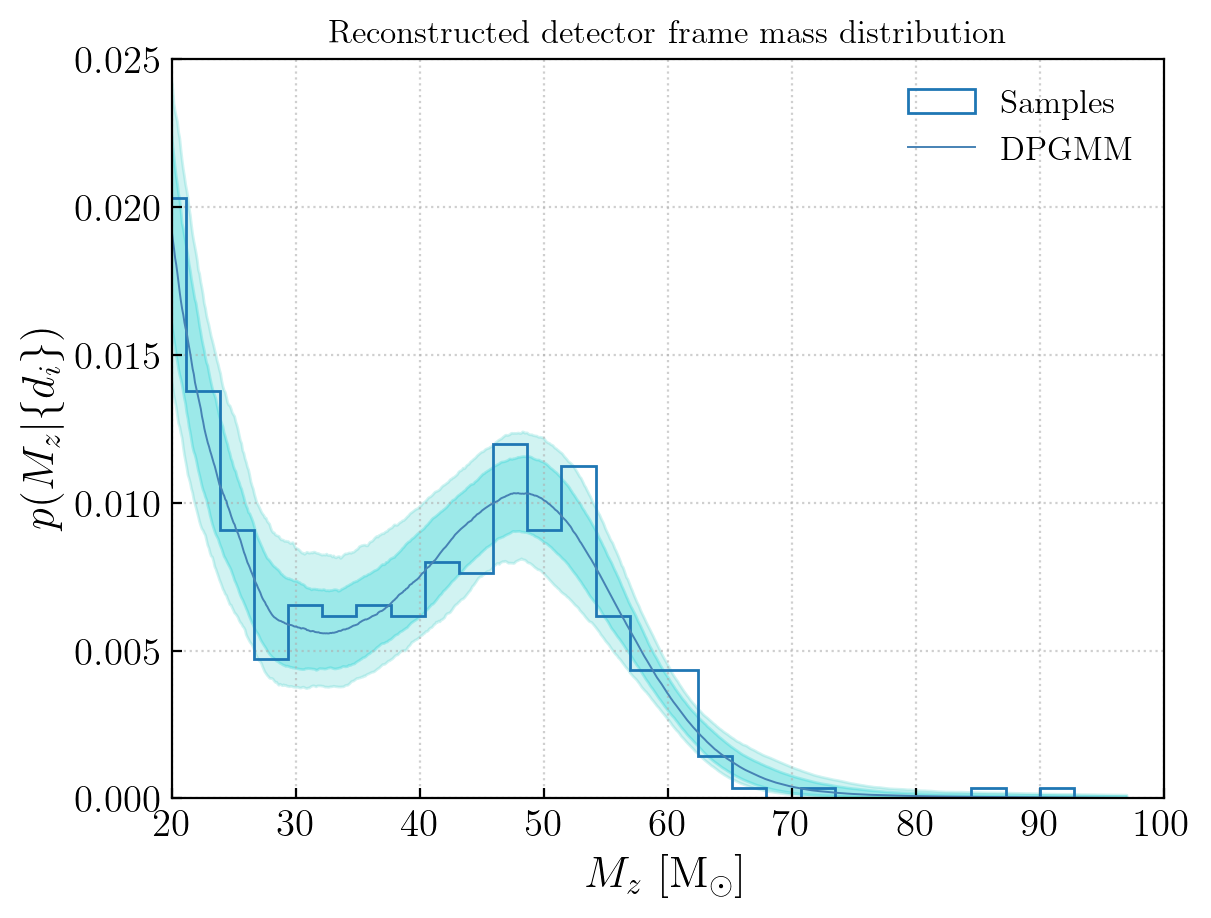

In [6]:
fig = plot_median_cr(draws_realistic, samples=data_realistic, save=True, show=False)
fig.axes[0].set_xlabel('$M_z\ [\mathrm{M}_\odot]$')
fig.axes[0].set_ylabel('$p(M_z|\{d_i\})$')
fig.axes[0].set_xlim(20,100)
fig.axes[0].set_ylim(0,0.025)
fig.axes[0].set_title('Reconstructed detector frame mass distribution')
fig.savefig('./observed_figaro.pdf', bbox_inches='tight')
fig

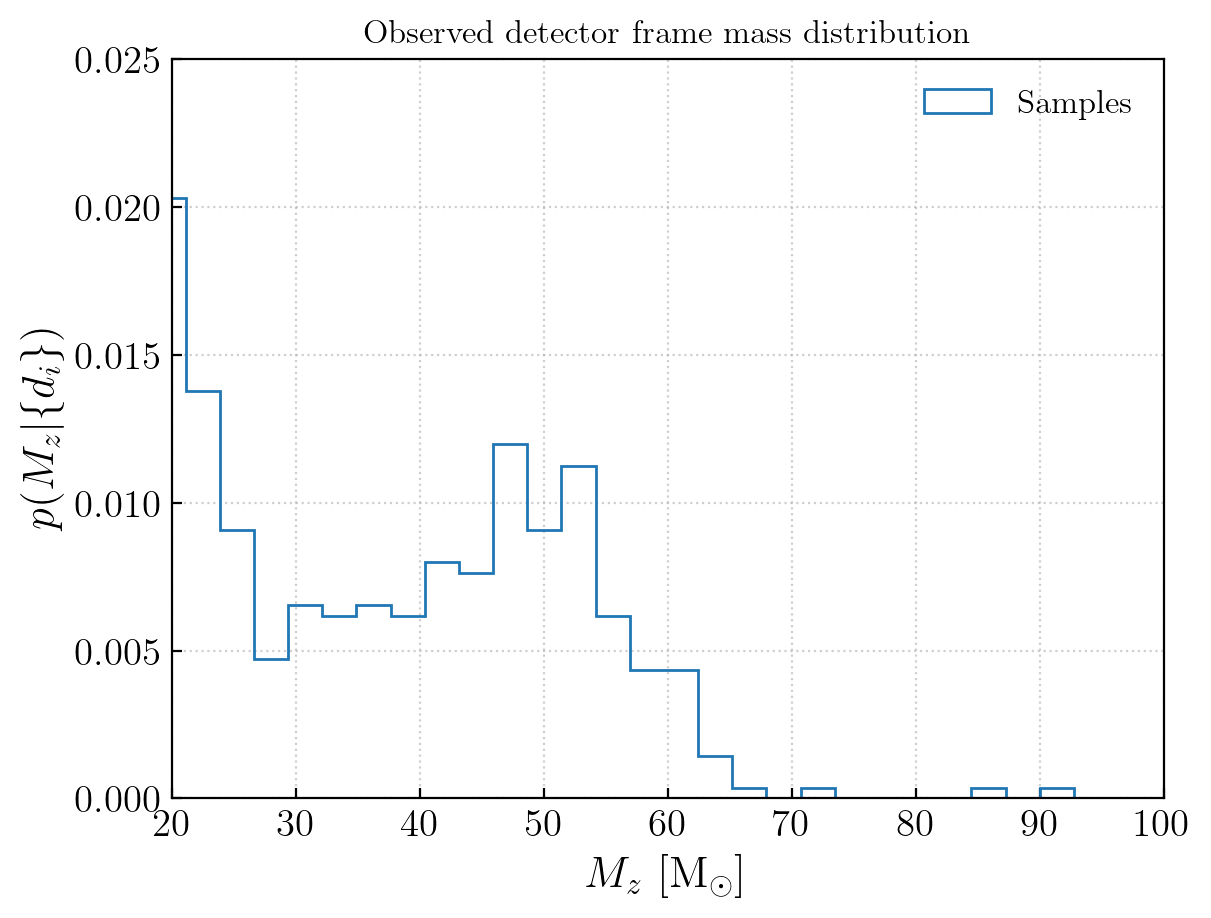

In [7]:
fig, ax = plt.subplots()
ax.hist(data_realistic, bins = int(np.sqrt(len(data_realistic))), histtype = 'step', density = True, label = '$\mathrm{Samples}$')
ax.set_xlabel('$M_z\ [\mathrm{M}_\odot]$')
ax.set_ylabel('$p(M_z|\{d_i\})$')
ax.set_xlim(20,100)
ax.set_ylim(0,0.025)
fig.axes[0].set_title('Observed detector frame mass distribution')
ax.legend()
fig.savefig('./observed_mass.pdf', bbox_inches='tight')
fig.show()